# Filialebericht-Generator 

Bitte führen die nächste Zelle aus, indem sie in die Zelle klicken und mit Strg+Enter bestätigen.  
Sie werden entweder ganz unten oder ganz oben (je nach verwendeter Software) nach der Eingabe Ihrer Filialnummer gefragt.  
Nummer eingeben, bestätigen und ganz unten den Bericht einsehen.

Bitte warten. Ihr Bericht wird generiert...


,Umsatz Prognose [€],Umsatz Gesamt [€],Kundenzahl Gesamt,Umsatz_pro_Tag [€],Kunden_pro_Tag,Umsatz_pro_Kunde[€],Leistung nach Umsatz pro Tag
14,319347,5231510,520107,5231510.0,520107.0,7803.543801,Oberes Mittelfeld


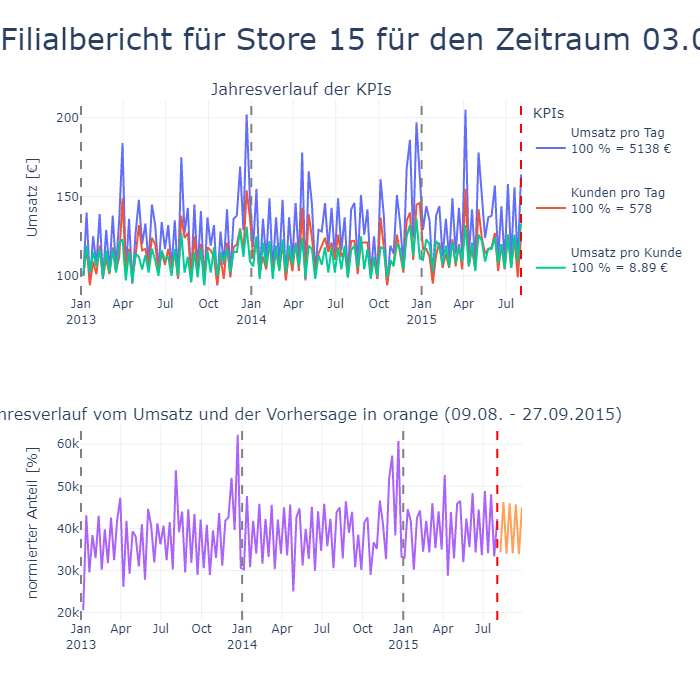

(None, None)

In [1]:

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

#plotten
import matplotlib.pyplot as plt
import seaborn as sns

#Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
import kaleido
import plotly.io as pio
pio.renderers.default = 'vscode+png'

from IPython.display import display, HTML
from functools import reduce
import joblib
import pyarrow as pa
from scipy.stats import anderson, randint, ttest_ind
pd.set_option('display.max_columns', None)

# machine Learning
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SelectPercentile, f_regression, RFE, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

selected_features= ['Gruppe', 'Promo', 'Wettbew_Distanz', 'Filiale', 'Kalenderwoche',
       'Wettbew_seit_Monaten', 'Wettbew_offen_seit_Monat',
       'Promo2_seit_Wochen', 'Promo2_seit_Woche',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos']
def generiere_report(Filialennummer):
    print("Bitte warten. Ihr Bericht wird generiert...")
    time.sleep(2)  # Simuliert eine Verzögerung von 2 Sekunden
    # Dein bestehender Code für generiere_report
    pass
    # Daten laden
    rf = joblib.load("..\\MachineLearning_Modell\\random_forest_model.joblib")
    df = pd.read_parquet("..\\Save_files\\df_data.parquet", engine='pyarrow')
    df_agg = pd.read_parquet("..\\Save_files\\df_agg.parquet", engine='pyarrow')
    df_transformed = pd.read_parquet("..\\Save_files\\df_transformed_data.parquet", engine='pyarrow')
    df_constructed = pd.read_parquet("..\\Save_files\\df_future_construct.parquet", engine='pyarrow')
   
    # Daten sortieren und Filiale auswählen
    df = df[df.Filiale == Filialennummer].copy()
    df = df.sort_values(["Datum"]).reset_index(drop=True).copy()
    df["Umsatz_pro_Tag"] = df.Umsatz//df.Geöffnet.round(0)
    df["Kunden_pro_Tag"] = df.Kundenzahl//df.Geöffnet.round(0)
    df["Umsatz_pro_Kunde"] = df.Umsatz / df.Kundenzahl.round(2)
    
    df_constructed = df_constructed[df_constructed.Filiale == Filialennummer].copy()
    df_constructed = df_constructed.sort_values(["Datum"]).reset_index(drop=True)
    
    # Umsatz für Filiale x vorhersagen
    # Test Daten
    X_test = df_constructed[selected_features]
    y_pred = rf.predict(X_test)
    
    #Vorhersage plotten
    df_vorhersage = df_constructed[["Datum"]].copy()
    # Rücktransformation der logarithmierten Werte
    y_future = np.exp(y_pred).astype(int).copy()
    y_rücktransformiert_df = pd.DataFrame({"Umsatz": y_future})
    df_vorhersage = pd.concat([df_vorhersage, y_rücktransformiert_df], axis=1)
    
    # Subplots erstellen
    fig = make_subplots(rows=2, cols=3, subplot_titles=("Jahresverlauf der KPIs","Jahresverlauf vom Umsatz und der Vorhersage in orange (09.08. - 27.09.2015)"),
                        specs=[[{"colspan": 3}, None, None], [{"colspan": 3}, None, None]])
 
    # normieren auf ersten wert
    df["Umsatz_pro_Kunde"] = round(df["Umsatz_pro_Kunde"], 2)
    metriken = ["Umsatz_pro_Tag", "Kunden_pro_Tag", "Umsatz_pro_Kunde"]
    metriken_normiert = ["Umsatz pro Tag", "Kunden pro Tag", "Umsatz pro Kunde"]
    df[metriken_normiert] = round(df[metriken].div(df[metriken].iloc[0].values) * 100)
    df_melt = pd.melt(df, id_vars=["Datum"], value_name="Anteil", value_vars=metriken_normiert, var_name="KPIs")
    
    fig1 = px.line(df_melt, x="Datum", y="Anteil", color="KPIs")
    for trace in fig1['data']:
        trace['showlegend'] = True 
        fig.add_trace(trace, row=1, col=1)
    
    
    df["isFuture"] = False
    df_vorhersage["isFuture"] = True
    df_combined = pd.concat([df, df_vorhersage], ignore_index=True)
    
    fig2 = px.line(df_combined, x='Datum', y="Umsatz", color="isFuture", color_discrete_sequence=px.colors.qualitative.Plotly[3:5])
    for trace in fig2['data']:
        trace['showlegend'] = False 
        fig.add_trace(trace, row=2, col=1)

    # Variablen in der Legende umbenennen
    fig.for_each_trace(lambda trace: trace.update(name=trace.name.replace("Umsatz pro Tag", f"Umsatz pro Tag<br>100 % = {df.Umsatz_pro_Tag.iloc[0]} €<br>")
                                                .replace("Kunden pro Tag", f"Kunden pro Tag<br>100 % = {df.Kunden_pro_Tag.iloc[0]} <br>")
                                                .replace("Umsatz pro Kunde", f"Umsatz pro Kunde<br>100 % = {df.Umsatz_pro_Kunde.iloc[0]} €<br>")
                                                ))
    # Vertikale linien für jedes jahr
    for year in [2013, 2014, 2015]:
        fig.add_vline(x=pd.Timestamp(f'{year}-01-01'), line=dict(dash='dash', color='gray'))
    fig.add_vline(x=pd.Timestamp(f'2015-08-02'), line=dict(dash='dash', color='red'))
    # jeden 3ten Monat zeigen    
    fig.update_xaxes(tickformat="%b\n%Y", dtick="M3")
    fig.update_layout(title_text=f"Filialbericht für Store {Filialennummer} für den Zeitraum 03.08. - 27.09.2015", title_font_size=30, title_x=0.0, template="plotly_white", height=700,
                    xaxis1_title="", yaxis1_title="Umsatz [€]",
                    xaxis2_title="", yaxis2_title="normierter Anteil [%]",
                    legend_title="KPIs")
        
    df_gesamt = df_agg[df_agg.Filiale == Filialennummer].copy()
    df_gesamt["Umsatz Prognose"] = df_vorhersage.Umsatz.sum().round().astype(int)
    df_gesamt = df_gesamt[["Umsatz Prognose", 'Umsatz', 'Kundenzahl', 'Umsatz_pro_Tag', "Kunden_pro_Tag", 'Umsatz_pro_Kunde', 'Gruppe',]]
    df_gesamt.columns = ["Umsatz Prognose [€]", 'Umsatz Gesamt [€]', 'Kundenzahl Gesamt', 'Umsatz_pro_Tag [€]', "Kunden_pro_Tag", 'Umsatz_pro_Kunde[€]', 'Leistung nach Umsatz pro Tag',]
    
    return display(df_gesamt), fig.show()

# Eingabeaufforderung erstellen
while True:
    try:
        Filialennummer = int(input("Bitte geben Sie eine Filialnummer zwischen 1 und 1115 ein: "))
        if 1 <= Filialennummer <= 1115:
            break
        else:
            print("Die Filialnummer muss zwischen 1 und 1115 liegen. Bitte versuchen Sie es erneut.")
    except ValueError:
        print("Ungültige Eingabe. Bitte geben Sie eine Zahl ein.")

# generiere_report mit der eingegebenen Filialnummer aufrufen
generiere_report(Filialennummer)
